In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from loader import PathDataModule
from tqdm import tqdm

# --- 1. Configuration and Data Loading ---
config_path = 'config_score.json'
config_data = json.load(open(config_path, 'r'))
print(config_data)

{'dataset': 'icews05-15', 'storage_dir': '../data/', 'embedding_config': './embedding_config.json', 'criteria': 'score', 'train_ratio': 0.3, 'hidden_dim': 256, 'max_hops': 6, 'num_neg': 3, 'num_threads': 4, 'decay_factor': 0.2, 'max_fanout': 100, 'beam_width': 20, 'max_epochs': 1, 'batch_size': 8, 'dim_feedforward': 256, 'nhead': 4, 'num_layers': 6, 'dropout': 0.1, 'store': 'model', 'save_text_embeddings': True, 'shallow': True, 'pre_scan': ['train'], 'adjust_no_neg_paths_samples': True, 'max_adjust': 5.0, 'positive_deviation': True, 'embedding': 'all', 'test_time': 1, 'num_ckpt': 2, 'scale_loss': True, 'chi2': False, 'lr': 0.0001, 'wandb_project': 'thesis-graph'}


In [2]:
tqdm.pandas()

In [3]:
import os, requests, json, pprint

cid  = os.getenv("CONTAINER_ID")          # ← set by Vast.ai inside every container
key  = os.getenv("CONTAINER_API_KEY")     # ← scoped token for this one instance
assert cid and key, "Not running on a Vast.ai container!"

resp = requests.get(
    f"https://console.vast.ai/api/v0/instances/{cid}/",
    headers={"Authorization": f"Bearer {key}",
             "accept": "application/json"},
    timeout=10,
)

info = resp.json()
print("Effective vCPUs:", info['instances']["cpu_cores_effective"])
# print(info['instances'].keys())

Effective vCPUs: 24.0


In [4]:

# Initialize the DataModule and load the data
print("Setting up DataModule...")
dm = PathDataModule(config_path=config_path, batch_size=32)
dm.setup('fit')
print("Data loaded.")


Setting up DataModule...
Setting up data for stage: fit
Setting up data for split: train
Negative paths file not found for train split: ../data/transe_icews05-15_train_neg.json. Skipping negative paths setup.
Pre-scan enabled for train split. Running full data validation...

--- Pre-scanning and filtering train data points ---
Scanning 1291900 edges in train split...


Scanning edges: 100%|██████████| 1291900/1291900 [00:02<00:00, 640101.98it/s]



Pre-scan Results for train:
  Total edges scanned: 1291900
  Valid edges (has pos & neg paths): 1070855 (82.9%)
  Missing positive paths: 221045 (17.1%)
  Missing negative paths: 1291900 (100.0%)
  Empty negative paths: 0 (0.0%)

⚠️  WARNING: Some edges are missing required path data!
  Filtering train split to keep only 1070855 valid edges.
  New edge count for train: 1070855
--- Pre-scan complete ---

Use shallow embeddings: True at config ./embedding_config.json
Loaded 1070855 edges for train split.
Setting up data for split: valid
Negative paths file not found for valid split: ../data/transe_icews05-15_valid_neg.json. Skipping negative paths setup.
Pre-scan not configured for valid split. Skipping data validation.
Use shallow embeddings: True at config ./embedding_config.json
Loaded 231510 edges for valid split.
Setting up data for split: test
Negative paths file not found for test split: ../data/transe_icews05-15_test_neg.json. Skipping negative paths setup.
Pre-scan not configur

In [5]:

# --- 2. Data Extraction and Preparation ---
plot_data = []
split = 'test'  # You can change this to 'valid' or 'test'

print(f"Processing data for '{split}' split...")
edges_df = dm.data[split]
pos_paths = dm.pos_paths[split]
neg_paths = dm.neg_paths[split]


Processing data for 'test' split...


In [6]:
print(len(pos_paths), len(neg_paths))

225073 0


In [7]:
edges_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230795 entries, 1744386 to 1975180
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   feat_pos_u  230795 non-null  int64
 1   feat_pos_v  230795 non-null  int64
 2   u           230795 non-null  int64
 3   v           230795 non-null  int64
 4   u_type      230795 non-null  int64
 5   v_type      230795 non-null  int64
 6   ts          230795 non-null  int64
 7   split       230795 non-null  int64
 8   label       230795 non-null  int64
 9   edge_type   230795 non-null  int64
 10  v_pos       230795 non-null  int64
 11  length      230795 non-null  int64
dtypes: int64(12)
memory usage: 31.0 MB


In [8]:
edges_df[edges_df['v_pos'] == edges_df['v']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 92318 entries, 1744386 to 1974916
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   feat_pos_u  92318 non-null  int64
 1   feat_pos_v  92318 non-null  int64
 2   u           92318 non-null  int64
 3   v           92318 non-null  int64
 4   u_type      92318 non-null  int64
 5   v_type      92318 non-null  int64
 6   ts          92318 non-null  int64
 7   split       92318 non-null  int64
 8   label       92318 non-null  int64
 9   edge_type   92318 non-null  int64
 10  v_pos       92318 non-null  int64
 11  length      92318 non-null  int64
dtypes: int64(12)
memory usage: 9.2 MB


In [9]:
edges_df[edges_df['v_pos'] == edges_df['v']].describe()

,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label,edge_type,v_pos,length
count,92318.000000,92318.000000,92318.000000,92318.000000,92318.0,92318.0,92318.000000,92318.0,92318.0,92318.000000,92318.000000,92318.000000
mean,487.428909,487.428909,1786.445688,1786.445688,0.0,0.0,91813.038064,3.0,1.0,145.105884,1786.445688,2.160467
std,1097.737907,1097.737907,2794.137687,2794.137687,0.0,0.0,2506.938435,0.0,0.0,128.324296,2794.137687,0.497563
min,0.000000,0.000000,0.000000,0.000000,0.0,0.0,87528.000000,3.0,1.0,0.000000,0.000000,0.000000
25%,9.000000,9.000000,56.000000,56.000000,0.0,0.0,89640.000000,3.0,1.0,10.000000,56.000000,2.000000
50%,76.000000,76.000000,369.000000,369.000000,0.0,0.0,91728.000000,3.0,1.0,250.500000,369.000000,2.000000
75%,383.000000,383.000000,2114.000000,2114.000000,0.0,0.0,94032.000000,3.0,1.0,261.000000,2114.000000,2.000000
max,10484.000000,10484.000000,10487.000000,10487.000000,0.0,0.0,96384.000000,3.0,1.0,501.000000,10487.000000,7.000000


In [10]:
edges_df.groupby(["u", "v_pos", "edge_type", "ts"]).count()

feat_pos_u  feat_pos_v  v  u_type  v_type  split  \
u     v_pos edge_type ts                                                        
0     44    3         93456           4           4  4       4       4      4   
                      93480           4           4  4       4       4      4   
                      95112           4           4  4       4       4      4   
            15        91872           4           4  4       4       4      4   
                      91944           4           4  4       4       4      4   
...                                 ...         ... ..     ...     ...    ...   
10484 56    23        96240           4           4  4       4       4      4   
            272       96240           1           1  1       1       1      1   
10485 7     10        96264           4           4  4       4       4      4   
10486 249   269       96288           1           1  1       1       1      1   
10487 6970  251       96336           1           1  1       1       1      1   

                             label  length  
u     v_pos edge_type ts                    
0     44    3         93456      4       4  
                      93480      4       4  
                      95112      4       4  
            15        91872      4       4  
                      91944      4       4  
...                            ...     ...  
10484 56    23        96240      4       4  
            272       96240      1       1  
10485 7     10        96264      4       4  
10486 249   269       96288      1       1  
10487 6970  251       96336      1       1  

[92318 rows x 8 columns]

In [11]:

for eid, row in tqdm(edges_df.iterrows(), total=len(edges_df), desc="Extracting paths"):
    eid_str = str(eid)
    label = row['label']
    u = row['u']
    v = row['v']
    ts = row['ts']
    v_pos = row['v_pos']
    edge_type = row['edge_type']
    edge_meta = {}

    # Process positive path
    if eid_str in pos_paths and pos_paths[eid_str].get('nodes'):
        pos_path_len = len(pos_paths[eid_str]['nodes'])
        edge_meta = {
            'path_length': pos_path_len,
            # 'path_type': 'positive',
            'label': label,
            'u': u, 'v': v, 'ts': ts, 'edge_type': edge_type,
            'v_pos': v_pos
            
        }
    else:
        edge_meta = {
            'path_length': 0,
            # 'path_type': 'positive',
            'label': label,
            'u': u, 'v': v, 'ts': ts, 'edge_type': edge_type,
            'v_pos': v_pos
        }

    # # Process negative paths
    # if eid_str in neg_paths:
    #     # for neg_path_interleaved in neg_paths[eid_str]:
    #     #     # As per loader.py, nodes are at even indices
    #     #     neg_path_len = len(neg_path_interleaved[::2])
    #     #     plot_data.append({
    #     #         'path_length': neg_path_len,
    #     #         'path_type': 'negative',
    #     #         'label': 'true_link' if label == 1 else 'false_link'
    #     #     })
    #     edge_meta["num_neg"] = len(neg_paths[eid_str])

    plot_data.append(edge_meta)

Extracting paths: 100%|██████████| 230795/230795 [00:07<00:00, 31231.03it/s]


In [12]:

plot_df = pd.DataFrame(plot_data)
print("Data prepared for plotting.")


Data prepared for plotting.


In [13]:
plot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230795 entries, 0 to 230794
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   path_length  230795 non-null  int64
 1   label        230795 non-null  int64
 2   u            230795 non-null  int64
 3   v            230795 non-null  int64
 4   ts           230795 non-null  int64
 5   edge_type    230795 non-null  int64
 6   v_pos        230795 non-null  int64
dtypes: int64(7)
memory usage: 12.3 MB


In [14]:
edges_fp = os.path.join(config_data['storage_dir'], f"{config_data['dataset']}_edges.csv")
df = pd.read_csv(edges_fp, index_col='edge_id')            
split_map = {str(idx): row['split'] for idx, row in tqdm(df.iterrows())}

1975181it [00:42, 46190.19it/s]


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1975181 entries, 0 to 1975180
Data columns (total 11 columns):
 #   Column      Dtype
---  ------      -----
 0   feat_pos_u  int64
 1   feat_pos_v  int64
 2   u           int64
 3   v           int64
 4   u_type      int64
 5   v_type      int64
 6   ts          int64
 7   split       int64
 8   label       int64
 9   edge_type   int64
 10  v_pos       int64
dtypes: int64(11)
memory usage: 180.8 MB


In [16]:
df[(df['v_pos'] == df['v']) & (df['split'] == 3)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 92318 entries, 1744386 to 1974916
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   feat_pos_u  92318 non-null  int64
 1   feat_pos_v  92318 non-null  int64
 2   u           92318 non-null  int64
 3   v           92318 non-null  int64
 4   u_type      92318 non-null  int64
 5   v_type      92318 non-null  int64
 6   ts          92318 non-null  int64
 7   split       92318 non-null  int64
 8   label       92318 non-null  int64
 9   edge_type   92318 non-null  int64
 10  v_pos       92318 non-null  int64
dtypes: int64(11)
memory usage: 8.5 MB


In [17]:
df[(df['label'] == 1) & (df['split'] == 3)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 92318 entries, 1744386 to 1974916
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   feat_pos_u  92318 non-null  int64
 1   feat_pos_v  92318 non-null  int64
 2   u           92318 non-null  int64
 3   v           92318 non-null  int64
 4   u_type      92318 non-null  int64
 5   v_type      92318 non-null  int64
 6   ts          92318 non-null  int64
 7   split       92318 non-null  int64
 8   label       92318 non-null  int64
 9   edge_type   92318 non-null  int64
 10  v_pos       92318 non-null  int64
dtypes: int64(11)
memory usage: 8.5 MB


In [18]:
df[(df['v_pos'] == df['u']) & (df['split'] == 3)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 1883670 to 1884322
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   feat_pos_u  5 non-null      int64
 1   feat_pos_v  5 non-null      int64
 2   u           5 non-null      int64
 3   v           5 non-null      int64
 4   u_type      5 non-null      int64
 5   v_type      5 non-null      int64
 6   ts          5 non-null      int64
 7   split       5 non-null      int64
 8   label       5 non-null      int64
 9   edge_type   5 non-null      int64
 10  v_pos       5 non-null      int64
dtypes: int64(11)
memory usage: 480.0 bytes


In [19]:
df.groupby(["u", "v_pos", "edge_type", "ts"]).count()

feat_pos_u  feat_pos_v  v  u_type  v_type  split  \
u     v_pos edge_type ts                                                        
0     1     0         0               1           1  1       1       1      1   
                      192             1           1  1       1       1      1   
                      216             1           1  1       1       1      1   
                      240             1           1  1       1       1      1   
                      17160           1           1  1       1       1      1   
...                                 ...         ... ..     ...     ...    ...   
10484 56    23        96240           4           4  4       4       4      4   
            272       96240           1           1  1       1       1      1   
10485 7     10        96264           4           4  4       4       4      4   
10486 249   269       96288           1           1  1       1       1      1   
10487 6970  251       96336           1           1  1       1       1      1   

                             label  
u     v_pos edge_type ts            
0     1     0         0          1  
                      192        1  
                      216        1  
                      240        1  
                      17160      1  
...                            ...  
10484 56    23        96240      4  
            272       96240      1  
10485 7     10        96264      4  
10486 249   269       96288      1  
10487 6970  251       96336      1  

[922658 rows x 7 columns]

In [20]:
df[df["split"] == 2].groupby(["u", "v_pos", "edge_type", "ts"]).count()

feat_pos_u  feat_pos_v  v  u_type  v_type  split  \
u     v_pos edge_type ts                                                        
0     44    3         82536           4           4  4       4       4      4   
                      82560           4           4  4       4       4      4   
                      83904           4           4  4       4       4      4   
            15        82536           4           4  4       4       4      4   
                      82560           4           4  4       4       4      4   
...                                 ...         ... ..     ...     ...    ...   
10100 424   9         87432           4           4  4       4       4      4   
            260       87432           1           1  1       1       1      1   
10101 9911  8         87432           4           4  4       4       4      4   
10102 2438  269       87432           1           1  1       1       1      1   
10103 78    3         87480           4           4  4       4       4      4   

                             label  
u     v_pos edge_type ts            
0     44    3         82536      4  
                      82560      4  
                      83904      4  
            15        82536      4  
                      82560      4  
...                            ...  
10100 424   9         87432      4  
            260       87432      1  
10101 9911  8         87432      4  
10102 2438  269       87432      1  
10103 78    3         87480      4  

[92604 rows x 7 columns]

In [21]:
# len(split_map.keys())

In [22]:
# list(split_map.values())[-1]

In [23]:
# split_code = {'pre': 0, 'train': 1, 'valid': 2, 'test': 3}

# print(f"Setting up data for split: {split}")

# pos_paths = {}
# with open(os.path.join(config_data['storage_dir'], f"{config_data['dataset']}_paths.txt")) as f:
#     n_str = f.readline()
#     n = int(n_str) if n_str and n_str.strip() else 0
#     for _ in tqdm(range(n)):
#         eid = f.readline().strip()
#         if not eid:
#             break
#         hops = int(f.readline())
#         nodes = [int(u) for u in f.readline().split()]
#         node_types = [int(t) for t in f.readline().split()]
#         edge_types_str = f.readline().strip().split()
#         edge_types = [int(et) for et in edge_types_str if et]
        
#         edge_timestamps_str = f.readline().strip().split()
#         edge_timestamps = [int(ts) for ts in edge_timestamps_str if ts]

#         if split_map.get(eid) == split_code[split]:
#             pos_paths[eid] = {
#                 "hops": hops,
#                 "nodes": nodes,
#                 "node_types": node_types,
#                 "edge_types": edge_types,
#                 "edge_timestamps": edge_timestamps
#             }


In [24]:
# len(pos_paths.keys())

In [25]:
plot_df

,path_length,label,u,v,ts,edge_type,v_pos
0,2,1,56,9,87528,18,9
1,3,1,56,849,87528,21,849
2,2,1,8228,40,87528,3,40
3,2,1,56,217,87528,32,217
4,2,1,2777,21,87528,1,21
...,...,...,...,...,...,...,...
230790,4,0,286,6080,96384,8,23
230791,4,0,286,5795,96384,8,23
230792,4,0,2202,9657,96384,30,9618
230793,4,0,2202,344,96384,30,9618


In [26]:
pos_df = plot_df[plot_df["path_length"] > 0].copy()
pos_df

,path_length,label,u,v,ts,edge_type,v_pos
0,2,1,56,9,87528,18,9
1,3,1,56,849,87528,21,849
2,2,1,8228,40,87528,3,40
3,2,1,56,217,87528,32,217
4,2,1,2777,21,87528,1,21
...,...,...,...,...,...,...,...
230790,4,0,286,6080,96384,8,23
230791,4,0,286,5795,96384,8,23
230792,4,0,2202,9657,96384,30,9618
230793,4,0,2202,344,96384,30,9618


In [27]:
temp = pos_df[pos_df["label"] == 1].groupby("path_length").count()
temp

,label,u,v,ts,edge_type,v_pos
path_length,,,,,,
2,76363,76363,76363,76363,76363,76363
3,13362,13362,13362,13362,13362,13362
4,1319,1319,1319,1319,1319,1319
5,248,248,248,248,248,248
6,18,18,18,18,18,18
7,2,2,2,2,2,2


In [28]:
temp / temp.sum() * 100

,label,u,v,ts,edge_type,v_pos
path_length,,,,,,
2,83.628658,83.628658,83.628658,83.628658,83.628658,83.628658
3,14.633345,14.633345,14.633345,14.633345,14.633345,14.633345
4,1.444498,1.444498,1.444498,1.444498,1.444498,1.444498
5,0.271596,0.271596,0.271596,0.271596,0.271596,0.271596
6,0.019713,0.019713,0.019713,0.019713,0.019713,0.019713
7,0.002190,0.002190,0.002190,0.002190,0.002190,0.002190


In [29]:
pos_df[pos_df["label"] == 0].groupby("path_length").count()

,label,u,v,ts,edge_type,v_pos
path_length,,,,,,
3,42980,42980,42980,42980,42980,42980
4,57789,57789,57789,57789,57789,57789
5,30058,30058,30058,30058,30058,30058
6,2434,2434,2434,2434,2434,2434
7,500,500,500,500,500,500


In [30]:
plot_df[plot_df["path_length"] < 2]

,path_length,label,u,v,ts,edge_type,v_pos
136,0,0,56,10470,87528,32,217
145,0,0,7601,10315,87528,20,5452
166,0,0,809,10392,87528,9,1099
174,0,0,147,10438,87528,8,5712
179,0,0,1187,10132,87528,17,487
...,...,...,...,...,...,...,...
230131,0,0,1465,5621,96360,1,21
230191,0,0,6738,6500,96360,1,150
230699,0,0,315,8381,96384,1,522
230723,0,0,120,10351,96384,1,206


In [31]:
def calculate_metrics(group):
    """
    Calculates MRR and Hits@K for a group of predictions for a single query.
    The group contains one 'true_link' and multiple 'false_link' rows.
    A lower 'path_length' is considered a better score.
    """
    true_link = group[group['label'] == 1]
    if true_link.empty or (true_link['path_length'].min() == 0):
        min_neg = 0 if group.loc[group['label'] == 1, 'path_length'].min() > 0 else 1
        return pd.Series({
            'rank': min_neg-1, 'mrr': min_neg, 'hits@1': min_neg, 'hits@3': min_neg, 'hits@10': min_neg
        })

    # Lower path_length is better.
    true_path_length = true_link['path_length'].min()
    
    # Rank is 1 + number of negative samples with a better (smaller) or equal path length.
    # We use '<=' because if scores are tied, the true link does not get the best rank.
    rank = 1 + group[(group['label'] == 0) & (group['path_length'] < true_path_length)].shape[0]
    
    mrr = 1.0 / rank
    hits_at_1 = 1.0 if rank <= 1 else 0.0
    hits_at_3 = 1.0 if rank <= 3 else 0.0
    hits_at_10 = 1.0 if rank <= 10 else 0.0
    
    return pd.Series({
        'rank': rank,
        'mrr': mrr,
        'hits@1': hits_at_1,
        'hits@3': hits_at_3,
        'hits@10': hits_at_10
    })


In [32]:

# Group by the query identifiers.
# This assumes that for each (u, v, ts, edge_type) combination that forms a true link,
# there are corresponding negative samples that share these identifiers in some way
# that allows grouping. If negative samples have different u or v, the grouping key needs adjustment.
# Based on the request, we group by ('u', 'v', 'ts', 'edge_type').
grouped = plot_df.groupby(['u', "v_pos", "edge_type", "ts"])


In [33]:

# Apply the function to each group and get the results.
metrics_df = grouped.progress_apply(calculate_metrics, include_groups=False).reset_index()


100%|██████████| 92318/92318 [01:07<00:00, 1375.86it/s]


In [34]:

print("Metrics per query:")
metrics_df


Metrics per query:


,u,v_pos,edge_type,ts,rank,mrr,hits@1,hits@3,hits@10
0,0,44,3,93456,1.0,1.0,1.0,1.0,1.0
1,0,44,3,93480,1.0,1.0,1.0,1.0,1.0
2,0,44,3,95112,1.0,1.0,1.0,1.0,1.0
3,0,44,15,91872,1.0,1.0,1.0,1.0,1.0
4,0,44,15,91944,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
92313,10484,56,23,96240,0.0,1.0,1.0,1.0,1.0
92314,10484,56,272,96240,0.0,1.0,1.0,1.0,1.0
92315,10485,7,10,96264,0.0,1.0,1.0,1.0,1.0
92316,10486,249,269,96288,0.0,1.0,1.0,1.0,1.0


In [35]:

print("\nAverage metrics across all queries:")
metrics_df[['mrr', 'hits@1', 'hits@3', 'hits@10']].mean() * 100



Average metrics across all queries:


mrr         97.824548
hits@1      95.818800
hits@3      99.958838
hits@10    100.000000
dtype: float64

<Axes: ylabel='Frequency'>

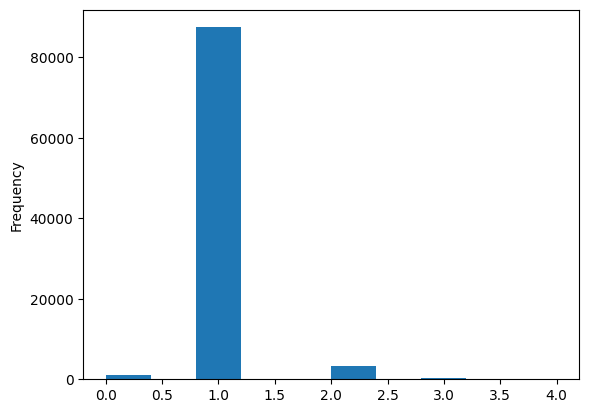

In [36]:
metrics_df['rank'].plot.hist(bins=10)

In [37]:
metrics_df.groupby('rank').count()

,u,v_pos,edge_type,ts,mrr,hits@1,hits@3,hits@10
rank,,,,,,,,
0.0,1006,1006,1006,1006,1006,1006,1006,1006
1.0,87452,87452,87452,87452,87452,87452,87452,87452
2.0,3409,3409,3409,3409,3409,3409,3409,3409
3.0,413,413,413,413,413,413,413,413
4.0,38,38,38,38,38,38,38,38


In [38]:
metric_names = ["mrr", "hits@1", "hits@3", "hits@10"]
time_metrics = metrics_df.groupby("ts")[metric_names].mean().reset_index()
time_metrics

,ts,mrr,hits@1,hits@3,hits@10
0,87528,0.948413,0.896825,1.0,1.0
1,87552,0.953390,0.906780,1.0,1.0
2,87576,0.961577,0.925150,1.0,1.0
3,87600,0.977663,0.958763,1.0,1.0
4,87624,0.956481,0.922222,1.0,1.0
...,...,...,...,...,...
365,96288,0.981132,0.962264,1.0,1.0
366,96312,0.984375,0.972656,1.0,1.0
367,96336,0.987395,0.974790,1.0,1.0
368,96360,0.994792,0.989583,1.0,1.0


<Axes: xlabel='ts'>

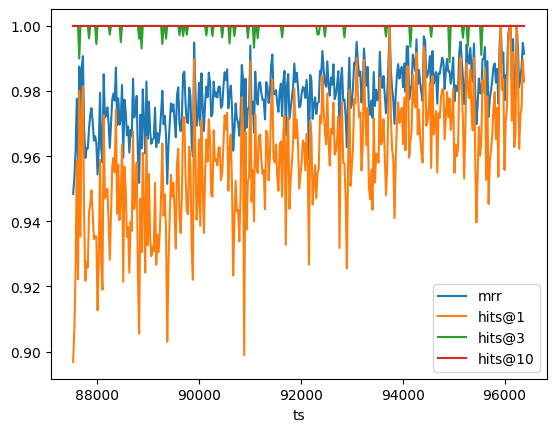

In [39]:
time_metrics.plot.line(x="ts", y=metric_names)

In [40]:
type_metrics = metrics_df.groupby("edge_type")[metric_names].mean().reset_index()
type_metrics

,edge_type,mrr,hits@1,hits@3,hits@10
0,0,0.958272,0.920039,0.998537,1.0
1,1,0.963554,0.929686,0.999186,1.0
2,2,0.930380,0.879747,1.000000,1.0
3,3,0.939290,0.880256,0.999086,1.0
4,4,0.915094,0.849057,1.000000,1.0
...,...,...,...,...,...
413,488,1.000000,1.000000,1.000000,1.0
414,491,1.000000,1.000000,1.000000,1.0
415,494,1.000000,1.000000,1.000000,1.0
416,500,1.000000,1.000000,1.000000,1.0


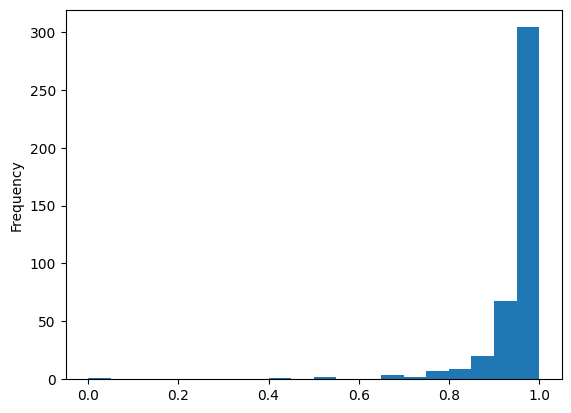

In [41]:
ax = type_metrics["hits@1"].plot.hist(bins=20)

In [42]:
results = pd.read_csv("../data/transe/icews14/thesis-graph/iostv0db/train_val_0_scores.csv")
results

,edge_id,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label,edge_type,v_pos,length,score
0,307232,0,33,44,211,0,0,7296,2,1,3,211,0,0.000000
1,307233,177,56,567,13,0,0,7296,2,1,70,13,0,0.000000
2,307234,13,0,27,44,0,0,7296,2,1,9,44,0,0.000000
3,307235,1,0,53,44,0,0,7296,2,1,32,44,0,0.000000
4,307236,102,3,590,8,0,0,7296,2,1,41,8,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42565,349797,5,6771,72,6711,0,0,7992,2,0,32,943,5,0.383389
42566,349798,5,5235,72,6196,0,0,7992,2,0,32,943,5,0.374265
42567,349799,44,5241,88,5917,0,0,7992,2,0,13,8,5,0.402574
42568,349800,44,2991,88,5587,0,0,7992,2,0,13,8,4,0.408247


In [43]:
len(results)

42570

In [44]:
len(results[results['label'] == 0])

25542

In [45]:
len(results[results['label'] == 1])

17028

In [46]:
results.iloc[0]

edge_id       307232.0
feat_pos_u         0.0
feat_pos_v        33.0
u                 44.0
v                211.0
u_type             0.0
v_type             0.0
ts              7296.0
split              2.0
label              1.0
edge_type          3.0
v_pos            211.0
length             0.0
score              0.0
Name: 0, dtype: float64

In [47]:
result_df = pd.DataFrame(results)
result_df

,edge_id,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label,edge_type,v_pos,length,score
0,307232,0,33,44,211,0,0,7296,2,1,3,211,0,0.000000
1,307233,177,56,567,13,0,0,7296,2,1,70,13,0,0.000000
2,307234,13,0,27,44,0,0,7296,2,1,9,44,0,0.000000
3,307235,1,0,53,44,0,0,7296,2,1,32,44,0,0.000000
4,307236,102,3,590,8,0,0,7296,2,1,41,8,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42565,349797,5,6771,72,6711,0,0,7992,2,0,32,943,5,0.383389
42566,349798,5,5235,72,6196,0,0,7992,2,0,32,943,5,0.374265
42567,349799,44,5241,88,5917,0,0,7992,2,0,13,8,5,0.402574
42568,349800,44,2991,88,5587,0,0,7992,2,0,13,8,4,0.408247


In [48]:
result_df.describe()

,edge_id,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label,edge_type,v_pos,length,score
count,42570.000000,42570.000000,42570.000000,42570.000000,42570.000000,42570.0,42570.0,42570.000000,42570.0,42570.000000,42570.000000,42570.000000,42570.000000,42570.000000
mean,328516.500000,537.759126,2360.519192,1124.978130,2563.367559,0.0,0.0,7645.099366,2.0,0.400000,70.126028,1021.909349,2.598332,0.222302
std,12289.044816,1042.529011,2290.092918,1699.161599,2258.919709,0.0,0.0,195.250129,0.0,0.489904,95.835064,1636.696323,2.203067,0.191982
min,307232.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,7296.000000,2.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,317874.250000,16.000000,159.000000,74.000000,407.000000,0.0,0.0,7488.000000,2.0,0.000000,9.000000,70.000000,0.000000,0.000000
50%,328516.500000,105.000000,1624.000000,372.000000,1990.500000,0.0,0.0,7656.000000,2.0,0.000000,25.000000,288.000000,3.000000,0.330330
75%,339158.750000,514.000000,4283.000000,1264.000000,4498.000000,0.0,0.0,7800.000000,2.0,1.000000,70.000000,1119.750000,4.000000,0.401864
max,349801.000000,7116.000000,7127.000000,6892.000000,7127.000000,0.0,0.0,7992.000000,2.0,1.000000,457.000000,6892.000000,7.000000,0.478551


In [49]:
result_df.groupby(["u", "v_pos", "edge_type", "ts"]).count()

edge_id  feat_pos_u  feat_pos_v  v  u_type  v_type  \
u    v_pos edge_type ts                                                         
0    1     0         7536        4           4           4  4       4       4   
                     7560        4           4           4  4       4       4   
                     7608        4           4           4  4       4       4   
                     7680        4           4           4  4       4       4   
                     7728        4           4           4  4       4       4   
...                            ...         ...         ... ..     ...     ...   
6889 1115  231       7992        1           1           1  1       1       1   
6890 4363  3         7992        4           4           4  4       4       4   
           233       7992        1           1           1  1       1       1   
6891 53    12        7992        4           4           4  4       4       4   
6892 1897  18        7992        4           4           4  4       4       4   

                           split  label  length  score  
u    v_pos edge_type ts                                 
0    1     0         7536      4      4       4      4  
                     7560      4      4       4      4  
                     7608      4      4       4      4  
                     7680      4      4       4      4  
                     7728      4      4       4      4  
...                          ...    ...     ...    ...  
6889 1115  231       7992      1      1       1      1  
6890 4363  3         7992      4      4       4      4  
           233       7992      1      1       1      1  
6891 53    12        7992      4      4       4      4  
6892 1897  18        7992      4      4       4      4  

[17028 rows x 10 columns]

In [50]:
df.describe()

,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label,edge_type,v_pos
count,1.975181e+06,1.975181e+06,1.975181e+06,1.975181e+06,1975181.0,1975181.0,1.975181e+06,1.975181e+06,1.975181e+06,1.975181e+06,1.975181e+06
mean,4.521144e+02,3.036188e+03,1.326502e+03,3.333629e+03,0.0,0.0,5.290489e+04,1.239028e+00,4.671258e-01,7.849680e+01,1.140889e+03
std,1.057961e+03,3.363698e+03,2.118848e+03,3.276825e+03,0.0,0.0,2.604634e+04,7.995885e-01,4.989182e-01,1.095580e+02,1.976026e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,7.400000e+01,5.600000e+01,2.530000e+02,0.0,0.0,3.163200e+04,1.000000e+00,0.000000e+00,8.000000e+00,5.400000e+01
50%,7.000000e+01,1.478000e+03,3.170000e+02,2.189000e+03,0.0,0.0,5.167200e+04,1.000000e+00,0.000000e+00,1.800000e+01,2.170000e+02
75%,3.500000e+02,5.715000e+03,1.681000e+03,6.015000e+03,0.0,0.0,7.624800e+04,1.000000e+00,1.000000e+00,1.160000e+02,1.291000e+03
max,1.048700e+04,1.048700e+04,1.048700e+04,1.048700e+04,0.0,0.0,9.638400e+04,3.000000e+00,1.000000e+00,5.010000e+02,1.048700e+04


In [51]:
df

,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label,edge_type,v_pos
edge_id,,,,,,,,,,,
0,206,17,0,1,0,0,0,0,1,0,1
1,1082,326,2,3,0,0,0,0,1,1,3
2,193,10,4,5,0,0,0,0,1,1,5
3,3,7,6,7,0,0,0,0,1,2,7
4,78,5,8,9,0,0,0,0,1,3,9
...,...,...,...,...,...,...,...,...,...,...,...
1975176,293,4330,286,6080,0,0,96384,3,0,8,23
1975177,293,3831,286,5795,0,0,96384,3,0,8,23
1975178,646,2683,2202,9657,0,0,96384,3,0,30,9618


In [52]:
test_df = pd.merge(df[df["split"] == 2], result_df, on=["u", "v_pos", "edge_type", "ts", "v", "label"])
test_df

,feat_pos_u_x,feat_pos_v_x,u,v,u_type_x,v_type_x,ts,split_x,label,edge_type,v_pos,edge_id,feat_pos_u_y,feat_pos_v_y,u_type_y,v_type_y,split_y,length,score


In [53]:
test_df.groupby(["u", "v_pos", "edge_type", "ts"]).count()

,,,,feat_pos_u_x,feat_pos_v_x,v,u_type_x,v_type_x,split_x,label,edge_id,feat_pos_u_y,feat_pos_v_y,u_type_y,v_type_y,split_y,length,score
u,v_pos,edge_type,ts,,,,,,,,,,,,,,,


In [54]:
test = result_df.groupby(["u", "v_pos", "edge_type", "ts"]).count()
test[test["v"] > 1]

edge_id  feat_pos_u  feat_pos_v  v  u_type  v_type  \
u    v_pos edge_type ts                                                         
0    1     0         7536        4           4           4  4       4       4   
                     7560        4           4           4  4       4       4   
                     7608        4           4           4  4       4       4   
                     7680        4           4           4  4       4       4   
                     7728        4           4           4  4       4       4   
...                            ...         ...         ... ..     ...     ...   
6883 607   9         7944        4           4           4  4       4       4   
6884 738   171       7968        4           4           4  4       4       4   
6890 4363  3         7992        4           4           4  4       4       4   
6891 53    12        7992        4           4           4  4       4       4   
6892 1897  18        7992        4           4           4  4       4       4   

                           split  label  length  score  
u    v_pos edge_type ts                                 
0    1     0         7536      4      4       4      4  
                     7560      4      4       4      4  
                     7608      4      4       4      4  
                     7680      4      4       4      4  
                     7728      4      4       4      4  
...                          ...    ...     ...    ...  
6883 607   9         7944      4      4       4      4  
6884 738   171       7968      4      4       4      4  
6890 4363  3         7992      4      4       4      4  
6891 53    12        7992      4      4       4      4  
6892 1897  18        7992      4      4       4      4  

[8514 rows x 10 columns]

In [55]:
from evaluation import evaluate
from collections import defaultdict

In [56]:
# edge_groups = defaultdict(lambda: {'pos_score': None, 'neg_scores': []})
# for item in results:
#     # Use v_pos as the target node for grouping, which is the true target for all edges
#     v_for_grouping = item.get('v_pos', item['v'])
#     key = (item['u'], item.get('edge_type'), v_for_grouping, item['ts'])
#     score = item['score']  # Now using the adjusted score
#     length = item['length']
    
#     if item['label'] == 1:
#         edge_groups[key]['pos_score'] = (score, length)
#     else:
#         edge_groups[key]['neg_scores'].append((score, length))

In [57]:
# final = evaluate(edge_groups, verbose=False)
final = evaluate(results, verbose=False)
final

({'rank': 0.31436457599248296,
  'mrr': 0.9635502309920914,
  'hits@1': 0.9379257693211182,
  'hits@3': 0.9891942682640357,
  'hits@10': 1.0},
           u  v_pos  edge_type    ts  rank  mrr  hits@1  hits@3  hits@10
 0         0      1          0  7536   0.0  1.0     1.0     1.0      1.0
 1         0      1          0  7560   0.0  1.0     1.0     1.0      1.0
 2         0      1          0  7608   0.0  1.0     1.0     1.0      1.0
 3         0      1          0  7680   0.0  1.0     1.0     1.0      1.0
 4         0      1          0  7728   0.0  1.0     1.0     1.0      1.0
 ...     ...    ...        ...   ...   ...  ...     ...     ...      ...
 17023  6889   1115        231  7992   0.0  1.0     1.0     1.0      1.0
 17024  6890   4363          3  7992   0.0  1.0     1.0     1.0      1.0
 17025  6890   4363        233  7992   0.0  1.0     1.0     1.0      1.0
 17026  6891     53         12  7992   0.0  1.0     1.0     1.0      1.0
 17027  6892   1897         18  7992   0.0  1.0     1.

In [58]:
test_df

,feat_pos_u_x,feat_pos_v_x,u,v,u_type_x,v_type_x,ts,split_x,label,edge_type,v_pos,edge_id,feat_pos_u_y,feat_pos_v_y,u_type_y,v_type_y,split_y,length,score


In [59]:
def process(group):
    return group.loc[group["label"] == 0, "length"].min()

In [60]:
test_df.groupby(["u", "v_pos", "edge_type", "ts"]).apply(process, include_groups=False)

,,,,feat_pos_u_x,feat_pos_v_x,v,u_type_x,v_type_x,split_x,label,edge_id,feat_pos_u_y,feat_pos_v_y,u_type_y,v_type_y,split_y,length,score
u,v_pos,edge_type,ts,,,,,,,,,,,,,,,


In [61]:
check = pd.merge(result_df, plot_df, on=["u", "v", "v_pos", "ts", "edge_type"])
check

,edge_id,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label_x,edge_type,v_pos,length,score,path_length,label_y


In [62]:
check_df = check[check['length'] != check['path_length']]
check_df

,edge_id,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label_x,edge_type,v_pos,length,score,path_length,label_y


In [63]:
check_df.describe()

,edge_id,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label_x,edge_type,v_pos,length,score,path_length,label_y
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
